In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

pd.options.display.max_columns = 50

In [2]:
# Import necessary packages
import sys 
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact
def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [4]:
df = pd.read_csv('subscribers.csv')
df.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [5]:
df.shape

(227628, 31)

In [6]:
a = np.array(df['current_sub_TF'])
print(a)
print(type(a))
print(a+0)
current_sub_TF = a+0


[ True  True False ...  True  True False]
<class 'numpy.ndarray'>
[1 1 0 ... 1 1 0]


In [7]:
churn_TF=[]
for i in current_sub_TF:
    if i == 1:
        i = 0 
        churn_TF.append(i)
    else:
        i=1
        churn_TF.append(i)

In [8]:
df['churn_TF'] = churn_TF

In [9]:
df = df[df['age']<100]

In [10]:
df = df.dropna(subset=['age', 'weekly_consumption_hour', 'num_ideal_streaming_services','churn_TF'])

In [11]:
df_dum = pd.get_dummies(df[['package_type','preferred_genre','intended_use','attribution_technical','male_TF']])

In [12]:
df=df.join(df_dum)

In [13]:
df=df.drop(columns=['package_type','preferred_genre','intended_use','attribution_technical','male_TF'])

In [14]:
df.head()

,Unnamed: 0,subid,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,country,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,...,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,male_TF_False,male_TF_True
2,496617,26844789,3.0,36.001186,2.0,25.0,UAE,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,681701,26723159,4.0,22.951579,3.0,28.0,UAE,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,192823,29726122,2.0,20.051667,2.0,61.0,UAE,search,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-02-19 18:30:15,2020-03-04 18:30:15,False,0.3303,ar,Standard Charter,14,True,1,2020-03-04 18:30:15,2020-07-04 18:30:15,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,315863,20299962,3.0,34.551230,2.0,23.0,UAE,referral,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-05 14:52:22,2020-03-19 14:52:22,False,0.0000,ar,RAKBANK,14,True,1,2020-03-19 14:52:22,2020-07-19 14:52:22,NaN,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,681969,23452753,3.0,28.751405,2.0,71.0,UAE,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-21 14:17:53,2020-02-04 14:17:53,False,0.3303,ar,NaN,14,False,0,NaN,NaN,2020-01-27 00:00:00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [15]:
df_sel = df[['age', 'weekly_consumption_hour', 'num_ideal_streaming_services']]
df_sel.head()

,age,weekly_consumption_hour,num_ideal_streaming_services
2,25.0,36.001186,2.0
4,28.0,22.951579,3.0
6,61.0,20.051667,2.0
7,23.0,34.551230,2.0
9,71.0,28.751405,2.0


In [20]:
df_sel.shape

(114922, 3)

In [21]:
df['churn_TF'].count()

114922

In [42]:
from sklearn.preprocessing import StandardScaler as st
df_n=st().fit(df_sel).transform(df_sel)
df_s=pd.DataFrame(df_n)
df_s

,0,1,2
0,-1.545742,1.664090,-0.249256
1,-1.319944,-1.045560,3.817905
2,1.163837,-1.647705,-0.249256
3,-1.696274,1.363017,-0.249256
4,1.916498,0.158729,-0.249256
...,...,...,...
114917,-0.115686,-0.142344,-0.249256
114918,-1.018879,0.459801,-0.249256
114919,-0.190952,-0.744488,-0.249256
114920,-0.567283,0.158729,-0.249256


In [24]:
# ----- READ IN DATA -----
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
#x_col_name = ['age', 'weekly_consumption_hour', 'num_ideal_streaming_services']
#'male_TF','package_type','preferred_genre','intended_use','attribution_technical']    # list of x covariates
# add_constant_TF = True

# --- preprocess data for model routine format requirements
# if add_constant_TF:
#     x_col_name.append('const')
#     df_train = sm.add_constant(df_train)
#     df_test = sm.add_constant(df_test)

In [25]:
import statsmodels.api as sm

In [32]:
aaa = df['churn_TF'].reset_index()
del aaa['index']

In [30]:
df_s

,0,1,2
0,-1.545742,1.664090,-0.249256
1,-1.319944,-1.045560,3.817905
2,1.163837,-1.647705,-0.249256
3,-1.696274,1.363017,-0.249256
4,1.916498,0.158729,-0.249256
...,...,...,...
114917,-0.115686,-0.142344,-0.249256
114918,-1.018879,0.459801,-0.249256
114919,-0.190952,-0.744488,-0.249256
114920,-0.567283,0.158729,-0.249256


In [34]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=aaa, exog=df_s)
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# --- fit logistic regression
logit_model = sm.Logit(endog=aaa, exog=df_s)
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                                 OLS Regression Results                                
Dep. Variable:               churn_TF   R-squared (uncentered):                   0.044
Model:                            OLS   Adj. R-squared (uncentered):              0.044
Method:                 Least Squares   F-statistic:                              1768.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):                        0.00
Time:                        18:14:04   Log-Likelihood:                     -1.1332e+05
No. Observations:              114922   AIC:                                  2.266e+05
Df Residuals:                  114919   BIC:                                  2.267e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

KeyError: 0

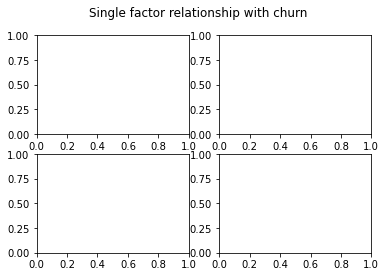

In [45]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
result = pd.DataFrame()
result['prob_churn_lpm'] = lpm_results.predict(df_s)
result['prob_churn_logit'] = logit_results.predict(df_s)

# plot predictions vs. data
select_plot_coef = [x for x in [0,1,2] if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(result[select_coef], result['churn_TF'],"g.")
        axes[i, j].plot(result[select_coef], result['prob_churn_lpm'], 'b.')
        axes[i, j].plot(dresult[select_coef], result['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

In [46]:
result.head()

,prob_churn_lpm,prob_churn_logit
0,-0.248656,0.254749
1,-0.295842,0.198552
2,0.243718,0.744415
3,-0.241253,0.261262
4,0.185131,0.690815


In [48]:
result.shape

(114922, 2)

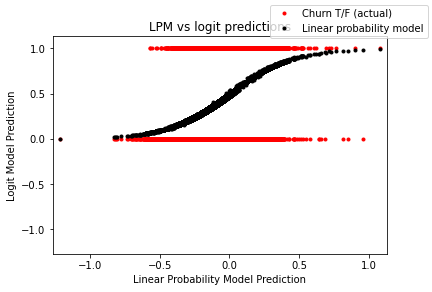

In [73]:
# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(result[['prob_churn_lpm']], df[['churn_TF']],'r.')
ax.plot(result[['prob_churn_lpm']], result[['prob_churn_logit']], 'k.')
plt.ylim(result[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, result[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

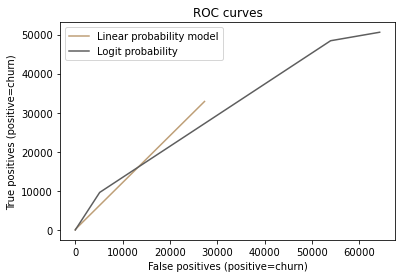

In [58]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df['churn_TF'], result['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df['churn_TF'], result['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, '#be9f77')
ax1.plot(logit_false_positives, logit_true_positives, '#5e5e5e')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [53]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df, df_impact = apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)


# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind





ValueError: Length of values (34477) does not match length of index (114922)